### Take a look at Joao's Todos Santos Bathymetries

This netCDF is a bathymetry file prepared for ROMS.

Downloaded from chaman in `/LUSTRE/jazevedo/baja/grid/baja_middle_new_grd.nc`

In [1]:
import cmocean as cmo
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from matplotlib.colors import TwoSlopeNorm

In [2]:
filename = '/Users/Karina/Tools/MITgcm-master/verification/internal_wave_BTS/input/baja_middle_new_grd.nc'
dat = xr.open_dataset(filename)

In [3]:
dat

<xarray.Dataset>
Dimensions:      (eta_rho: 125, xi_rho: 306, one: 1, eta_psi: 124, xi_psi: 305, eta_u: 125, xi_u: 305, eta_v: 124, xi_v: 306)
Dimensions without coordinates: eta_rho, xi_rho, one, eta_psi, xi_psi, eta_u, xi_u, eta_v, xi_v
Data variables: (12/33)
    angle        (eta_rho, xi_rho) float64 ...
    dmde         (eta_rho, xi_rho) float64 ...
    dndx         (eta_rho, xi_rho) float64 ...
    el           (one) float64 ...
    f            (eta_rho, xi_rho) float64 ...
    h            (eta_rho, xi_rho) float64 ...
    ...           ...
    theta_s      float64 ...
    theta_b      float64 ...
    Tcline       float64 ...
    hc           float64 ...
    Vtransform   float64 ...
    Vstretching  float64 ...

I'll use `h` (bathymetry at RHO-points), with dimensions `eta_rho` and `xi_rho`.

NameError: name 'levels2' is not defined

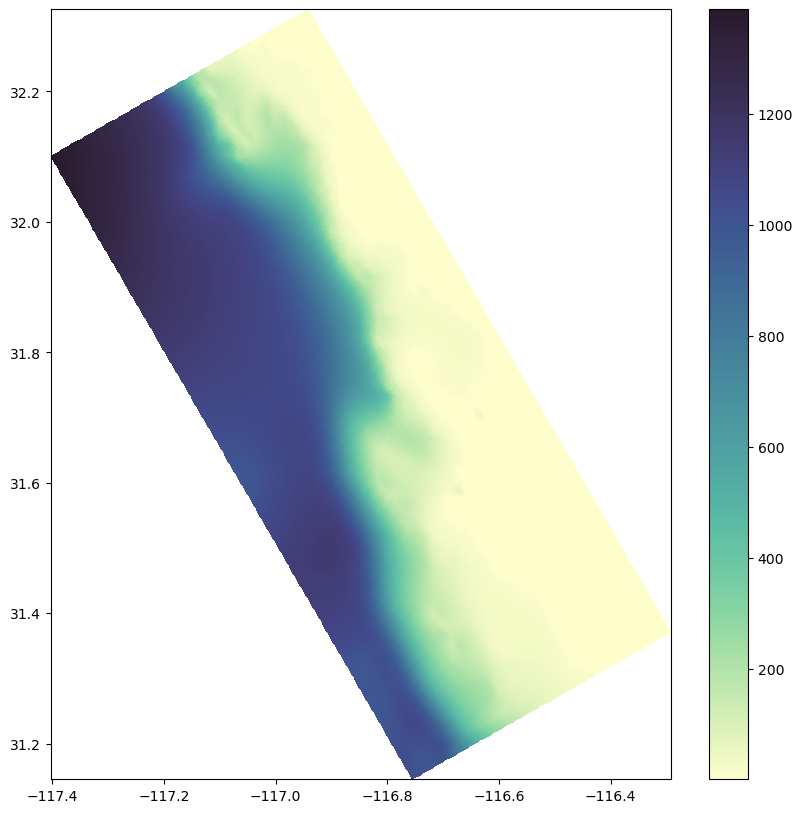

In [4]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
pc = ax.pcolormesh(dat.lon_rho, dat.lat_rho, dat.h, cmap=cmo.cm.deep)
plt.colorbar(pc)
levels = np.linspace(1,101,10)

ax.contour(dat.lon_rho, dat.lat_rho, dat.h, levels=levels2, colors=['0.5'])
ax.set_aspect('equal')

I don't think the canyon is there...
Zoom in?

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
pc = ax.pcolormesh(dat.lon_rho[50:,100:-100], 
                   dat.lat_rho[50:,100:-100], 
                   dat.h[50:,100:-100],
                   cmap=cmo.cm.deep)
plt.colorbar(pc)
levels = np.linspace(1,101,10)

ax.contour(dat.lon_rho[50:,100:-100], 
           dat.lat_rho[50:,100:-100], 
           dat.h[50:,100:-100], 
           levels=levels2, colors=['0.5'])
ax.set_aspect('equal')

No canyon, resolution is too low.

Let's try another bathy:

In [ ]:
filename2 = '/Users/Karina/Tools/MITgcm-master/verification/internal_wave_BTS/input/baja_BTS_new_grd.nc'
dat2 = xr.open_dataset(filename2)

In [ ]:
dat2

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
mask = np.ma.getmask(np.ma.masked_equal(dat2.mask_rho.data, 0))

pc = ax.pcolormesh(dat2.lon_rho, dat2.lat_rho, 
                   np.ma.masked_array(dat2.h*dat2.mask_rho, mask=mask), 
                   cmap=cmo.cm.deep)
plt.colorbar(pc)
levels = np.linspace(0,100,10)

ax.contour(dat2.lon_rho, dat2.lat_rho, dat2.h*dat2.mask_rho , levels=levels2, colors=['0.5'])
ax.set_aspect('equal')

This domain will not be useful as it is since the bay and canyon are too close to the boundaries. Maybe I'm wrong, but I'll try something else. I don't like the way things work with the bathy and the mask because this bathy is prepared for sigma coords (see contours around the island). May be it would be easier if I just get a piece of GEBCO to begin with.

I do like the idea of having a skewed domain to save computational resources, though. Tha way it was done in the Salish Sea Model. How do you do that in MITgcm? Well, exch2 will deal with land nodes, anyway.

### GEBCO download

Let's see what I got form GEBCO:

In [ ]:
filename3 = '/Users/Karina/Research/Canyons/internalWaves/data/bathy/GEBCO_03_Jun_2023_b0c4bc49ccad/gebco_2023_n32.3_s31.4_w-117.379_e-116.5.nc'
dat3 = xr.open_dataset(filename3)

In [ ]:
dat3

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

norm = TwoSlopeNorm(vmin=dat3.elevation.min(), vcenter=0, vmax=dat3.elevation.max())
pc = ax.pcolormesh(dat3.lon, dat3.lat, dat3.elevation,
                   norm=norm, cmap=cmo.cm.topo)
plt.colorbar(pc, label='elevation (m)')
cn = ax.contour(dat3.lon, dat3.lat, dat3.elevation, levels=[-1000,-500,-250,-100])

ax.axhline(32.0, color='r')
ax.axhline(31.6, color='r')
ax.axvline(-117.1, color='r')
ax.axvline(-116.6, color='r')

ax.set_aspect('equal')
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')
plt.show()
print('Levels are: yellow -100 m, -250,-500, purple -1000 m')

Ok, looks like a good initial domain, may be a bit too large. I think the box in red would be better (N 32.0, S 31.6, W -117.1, E -116.6). I'll smooth it out a bit, cut it at 1400 m, remove some of the lonely pixels along the coastline and prepare for MITgcm in notebook `prepare_bathy0_from_gebco.ipynb`.